In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
# Set plot style
sns.set_style('whitegrid')

In [2]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [3]:
df = pd.read_csv('21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')
print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## EDA

In [4]:
# Basic info and statistics
print("Dataset Info:")
df.info()

# Drop the CustomerID as it's just an identifier and not useful for clustering
df.drop('CustomerID', axis=1, inplace=True)

print("\nDescriptive Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Descriptive Statistics:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     4

### Univariate Analysis

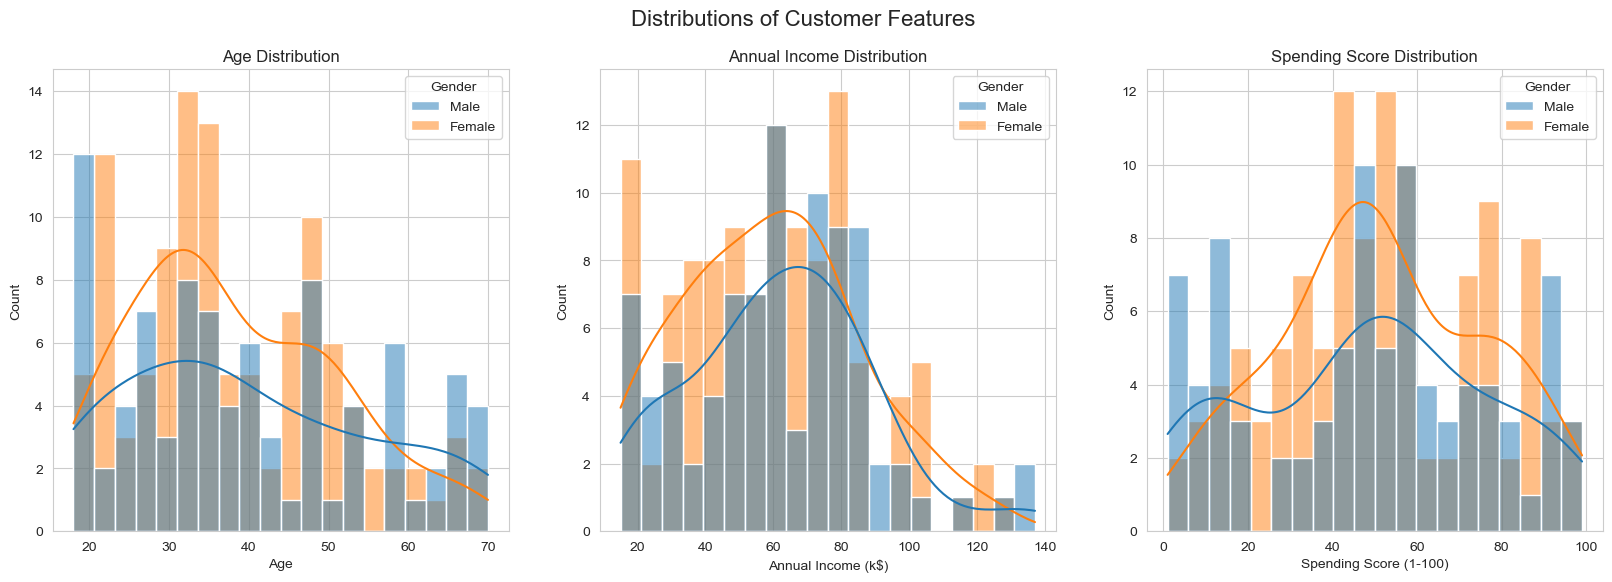

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=df, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=df, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=df, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

### Bivariate Analysis

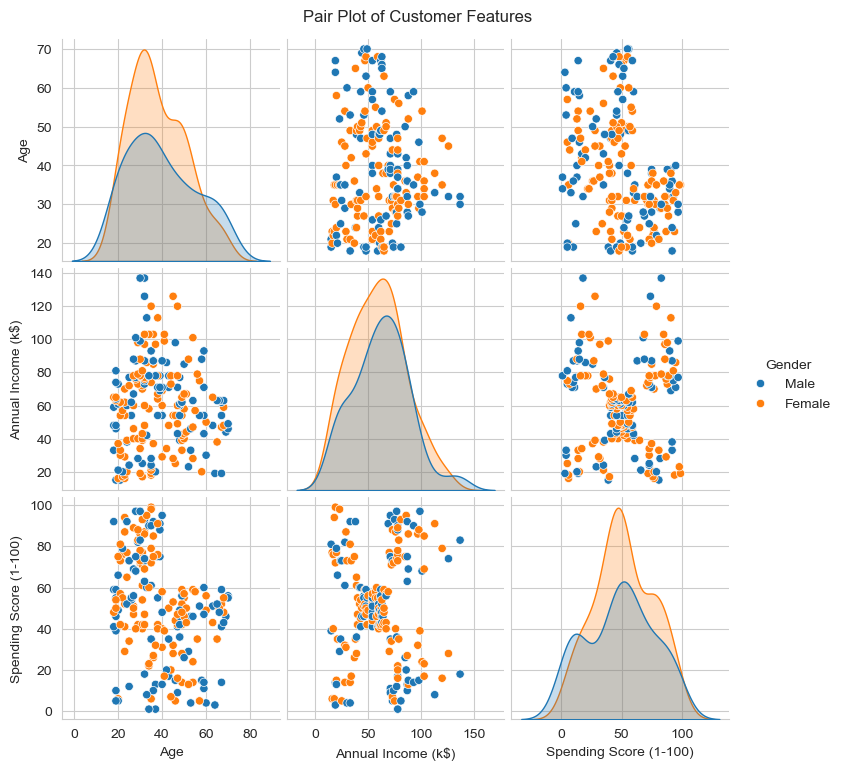

In [6]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(df, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

### Inference:
- Annual income vs Spending score: shows distinct groups
- Age vs Spending score: high-spending customers in younger age brackets
- Gender: largly overlaps (not a strong seperating feature)

In [7]:
fig = px.scatter_3d(df,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

### Segmentation Model 1: Income and Spending Score

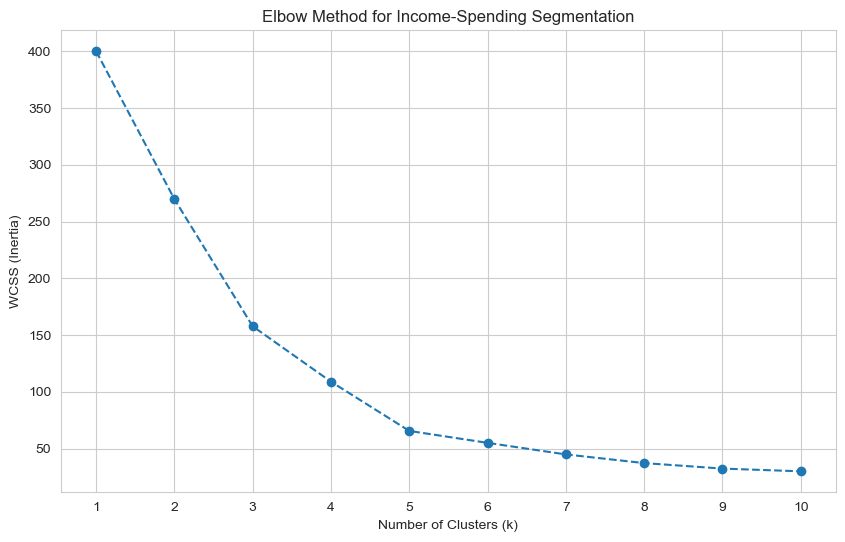

In [8]:
# 1. Select and scale the features
X1 = df[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

### Inference:
- The "elbow" of the curve is at k=5. (The WCSS decreases sharply until k=5, and then the rate of decrease flattens out)

In [9]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
df['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

### Visualizing and Interpreting the Income-Based Segments

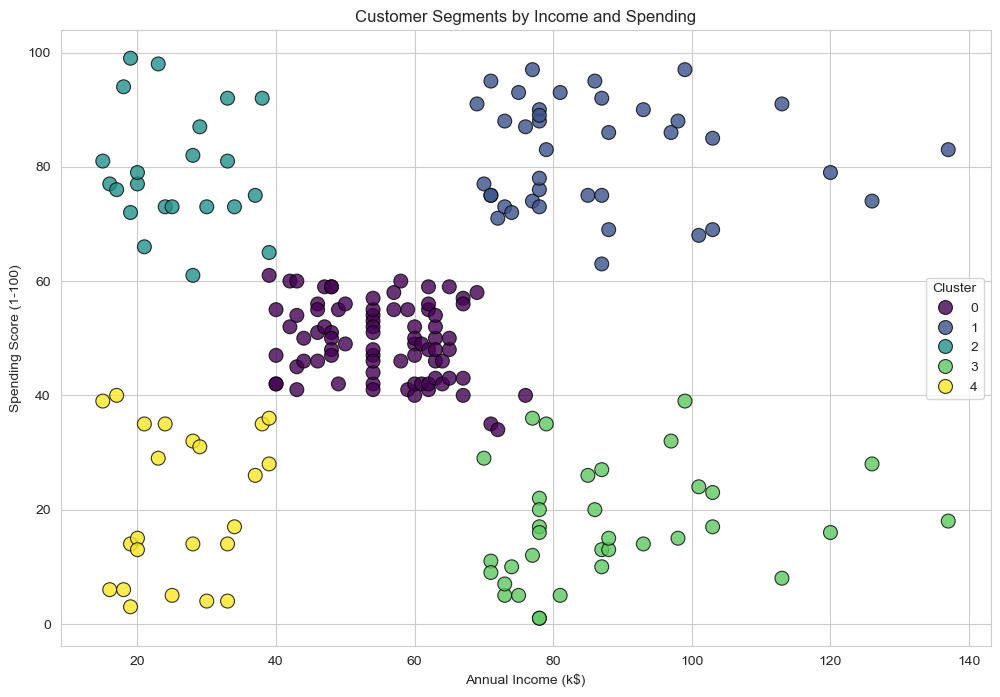

In [10]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

In [11]:
# Quantitative Persona Analysis
cluster_profiles1 = df.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = df['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


### Inferenece:
- Cluster 0: Major people lies in category of mid-income and mid-expense.
- Cluster 1: moderate people are there in category of high-income and high-expense.
- Cluster 2: less people lies in the category of low-income but high-expense.
- Cluster 3: moderate people are there in the category of high-income and less-expense.
- Cluster 4: less poeple lies under category of low-income and low-expense.

### Segmentation Model 2: Age and Spending Score

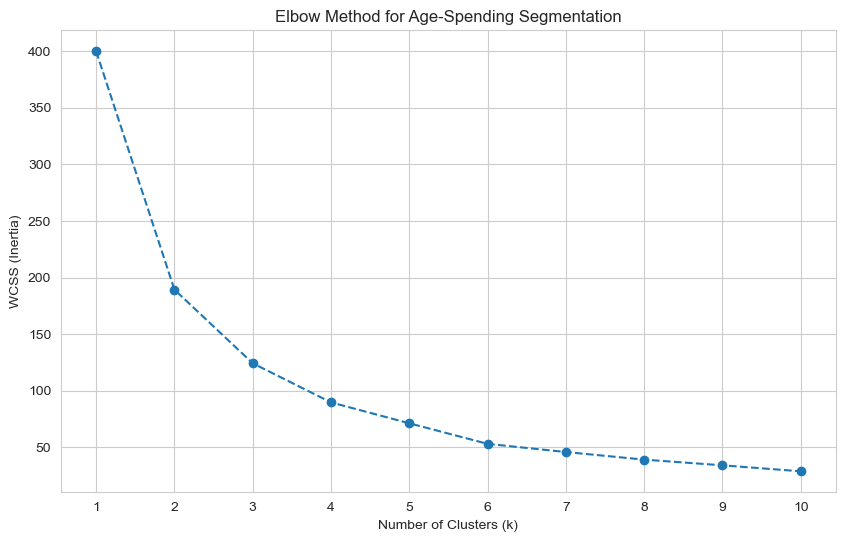

In [12]:
# 1. Select and scale the features
X2 = df[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

### Inference: 
- The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

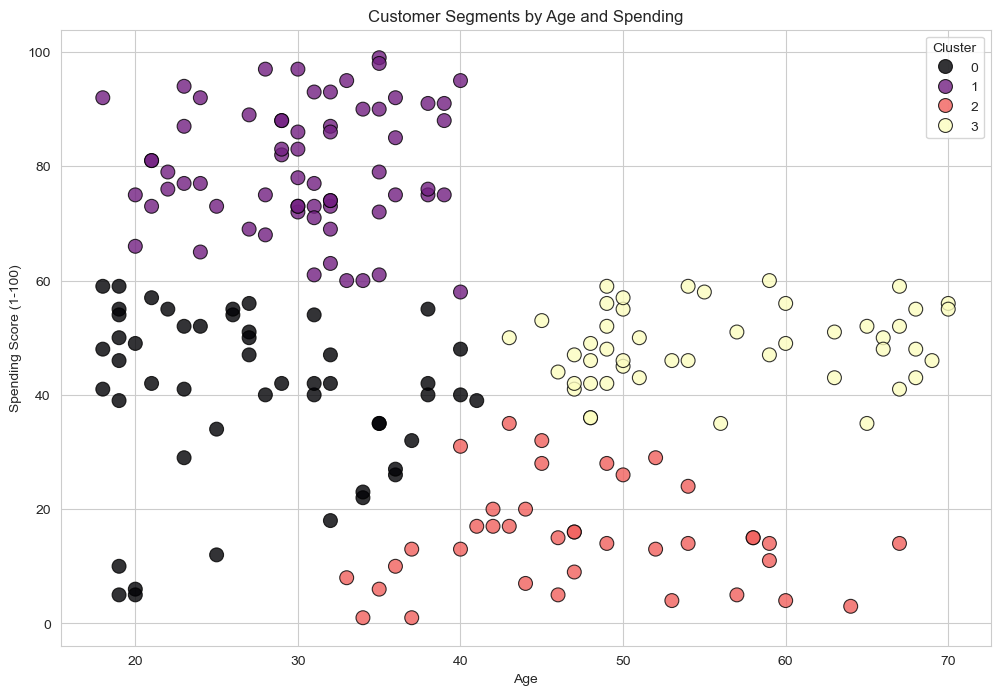

In [13]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

### Inference:
- Young low-spender: Customers with age group less than 40, spending score <=60
- 